# OpenStreetMap example

In this example, we download a road network from OSM using the OSMNx package, and then process the result, resulting in a RouteE Compass network dataset.

## requirements

To download an open street maps dataset, we'll need some extra dependnecies which are included with the conda distribution of this pacakge: 

```console
conda create -n routee-compass -c conda-forge python=3.11 nrel.routee.compass 
```

In [1]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt

from nrel.routee.compass.io import generate_compass_dataset
from nrel.routee.compass import CompassApp

## Building RouteE Compass Dataset

### Get OSM graph

First, we need to get an OSM graph that we can use to convert into the format RouteE Compass expects.

In this example we will load in a road network that covers Denver, Colorado as an example, but this workflow will work with any osmnx graph (osmnx provides [many graph download operations](https://osmnx.readthedocs.io/en/stable/user-reference.html#module-osmnx.graph)).

In [2]:
g = ox.graph_from_place("Denver, Colorado, USA", network_type="drive")  

### Convert Graph to Compass Dataset

Now, we call the `generate_compass_dataset` function which will convert the osmnx graph into files that are compatible with RouteE Compass.

```{note}
In order to get the most accurate energy results from the routee-powertrain vehicle models, it's important to include road grade information since it plays a large factor in vehicle energy consumption (`add_grade=True`)
That being said, adding grade can be a big lift computationally. In our case, we pull digital elevation model (DEM) raster files from USGS and then use osmnx to append elevation and grade to the graph. If the graph is large, this can take a while to download and could take up a lot of disk space.
So, we recommend that you include grade information in your graph but want to be clear about the requirements for doing so.
```

In [3]:
generate_compass_dataset(g, output_directory="denver_co", add_grade=True)      

processing graph topology and speeds
adding grade information
processing vertices
processing edges
writing vertex files
writing edge files
writing edge attribute files
copying default configuration TOML files
copying RouteE Powertrain models


This will parse the OSM graph and write the RouteE Compass files into a new folder "denver_co/". If you take a look in this directory, you'll notice some `.toml` files like: `osm_default_energy.toml`. 
These are configurations for the compass application. Take a look [here](https://nrel.github.io/routee-compass/config.html) for more information about this file.

## Running

### Load Application

Now we can load the application from one of our config files. 
We'll pick `osm_default_energy.toml` for computing energy optimal routes.

In [4]:
app = CompassApp.from_config_file("denver_co/osm_default_energy.toml")  

uuid file: 100%|██████████| 16992/16992 [00:00<00:00, 5900426.50it/s]/s]

###  Queries

With our application loaded we can start computing routes by passing queries to the app.
To demonstrate, we'll route between two locations in Denver, CO utilzing the grid search input plugin to run three separate searches. 

The `model_name` is the vehicle we want to use for the route. If you look in the folder `denver_co/models` you'll see a collection of routee-powertrain models that can be used to compute the energy for your query.

The `vehicle_state_variable_rates` section defines rates to be applied to each component of the cost function. In this case we use the following costs:

 - 0.655 dollars per mile
 - 20 dollars per hour (or 0.333 dollars per minute)
 - 3.12 dollars per gallon of gas

The `grid_search` section defines our test cases.
Here, we have three cases: [`least_time`, `least_energy`, `least_cost`].  
In the least_time and least_energy cases, we zero out all other variable contributions using the `state_variable_coefficients` which always get applied to each cost componenet.
In the least_cost case, we allow each cost component to contribute equally and the algorithm will minimize the resulting cost from all components being added together (after getting multiplied by the appropriate `vehicle_state_variable_rate`.

In [20]:
query = [
    {
        "origin_name": "Central Park",
        "destination_name": "Washington Park",
        "origin_x": -104.890432,
        "origin_y": 39.772997,
        "destination_x": -104.975360,
        "destination_y": 39.693005,
        "model_name": "2016_TOYOTA_Camry_4cyl_2WD",
        "vehicle_state_variable_rates": {
            "distance": {"type": "factor", "factor": 0.655},
            "time": {"type": "factor", "factor": 0.33333},
            "energy_liquid": {"type": "factor", "factor": 3.12},            
        },
        "grid_search": {
            "test_cases": [
              {
                "name": "least_time",
                "state_variable_coefficients": {
                  "distance": 0,
                  "time": 1,
                  "energy_liquid": 0
                }
              },
              {
                "name": "least_energy",
                "state_variable_coefficients": {
                  "distance": 0,
                  "time": 0,
                  "energy_liquid": 1
                }
              },
              {
                "name": "least_cost",
                "state_variable_coefficients": {
                  "distance": 1,
                  "time": 1,
                  "energy_liquid": 1
                }
              }
            ]
          }    
    },
]

Now, let's pass the query to the application.

```{note}
A query can be a single object, or, a list of objects.
If the input is a list of objects, the application will run these queries in parallel over the number of threads defined in the config file under the `paralellism` key (defaults to 2).
```

In [21]:
results = app.run(query)

search: 100%|██████████| 3/3 [00:00<00:00, 54.37it/s]6.17it/s]

## Analysis

The application returns the results as a list of python dictionaries.
Since we used the grid search to specify three separate searches, we should get three results back:

In [23]:
len(results)

3

### Summary

First let's pull out the results from the list of returned results.

In [25]:
least_time_result = next(filter(lambda r: r["request"]["name"] == "least_time", results))
least_energy_result = next(filter(lambda r: r["request"]["name"] == "least_energy", results))
least_cost_result = next(filter(lambda r: r["request"]["name"] == "least_cost", results))

To demonstrate what the results contain we'll take a look at the summary of the least_cost scenario:

In [28]:
least_cost_result["traversal_summary"]

{'distance': 9.888214419271453,
 'distance_unit': 'miles',
 'time': 18.537209692469048,
 'time_unit': 'minutes',
 'vehicle': {'energy_liquid': 0.3718807733781823},
 'vehicle_info': {'energy_unit': 'gallons_gasoline'}}

In [29]:
least_cost_result["cost_summary"]

{'cost': {'distance': 6.4767804446228014,
  'energy_liquid': 1.1602680129399288,
  'time': 6.179008106790708,
  'total_cost': 13.816056564353438},
 'info': {'cost_aggregation': 'sum',
  'network_state_variable_rates': [{'type': 'zero'},
   {'type': 'zero'},
   {'type': 'zero'}],
  'state_variable_coefficients': [1.0, 1.0, 1.0],
  'state_variable_indices': [['distance', 0],
   ['time', 1],
   ['energy_liquid', 2]],
  'vehicle_state_variable_rates': [{'factor': 0.655, 'type': 'factor'},
   {'factor': 0.33333, 'type': 'factor'},
   {'factor': 3.12, 'type': 'factor'}]}}

In addition to the summary, the result also contains much more information.
Here's a list of all the different sections that get returned:

In [30]:
least_cost_result.keys()

dict_keys(['algorithm_runtime', 'basic_summary_runtime', 'cost_summary', 'destination_vertex_uuid', 'iterations', 'origin_vertex_uuid', 'output_plugin_executed_time', 'request', 'result_memory_usage_bytes', 'route', 'route_edge_count', 'search_app_runtime', 'search_executed_time', 'traversal_summary', 'tree_edge_count'])

### Plotting

We can also plot the results to see the difference between the routes.

In [31]:
from nrel.routee.compass.plot import plot_route_folium, plot_routes_folium

We can use the `plot_route_folium` function to plot single routes, passing in the `line_kwargs` parameter to customize the folium linestring:

In [32]:
m = plot_route_folium(least_time_result, line_kwargs={"color": "red", "tooltip": "Shortest Time"})
m = plot_route_folium(least_energy_result, line_kwargs={"color": "green", "tooltip": "Least Energy"}, folium_map=m)
m = plot_route_folium(least_cost_result, line_kwargs={"color": "blue", "tooltip": "Least Cost"}, folium_map=m)
m

We can also use the plot_routes_folium function and pass in multiple results. The function will color the routes based on the `value_fn` which takes a single result as an argument. For example, we can tell it to color the routes based on the total energy usage. 

In [33]:
m = plot_routes_folium(results, value_fn=lambda r: r["traversal_summary"]["vehicle"]["energy_liquid"], color_map="plasma")
m

### Tradeoffs

Lastly, let's look at the tradeoffs for taking one route versus another.

First we'll gather some of the summary values into a dataframe:

In [15]:
c = []
for r in results:
    c.append({ 
        "scenario": r["request"]["name"],
        "time_minutes": r["traversal_summary"]["time"],
        "distance_miles": r["traversal_summary"]["distance"],
        "energy_gge": r["traversal_summary"]["vehicle"]["energy_liquid"],
        "cost_dollars": r["cost_summary"]["cost"]["total_cost"],
    })

In [16]:
df = pd.DataFrame(c)

In [17]:
df

,scenario,time_minutes,distance_miles,energy_gge,cost_dollars
0,time,16.531571,13.536348,0.477834,15.867617
1,cost,18.537210,9.888214,0.371881,13.816057
2,energy,19.844078,9.962278,0.356878,14.253379


Now, let's look at the tradeoff between time and cost.

Text(0.5, 1.0, 'Cost vs Time by Scenario')

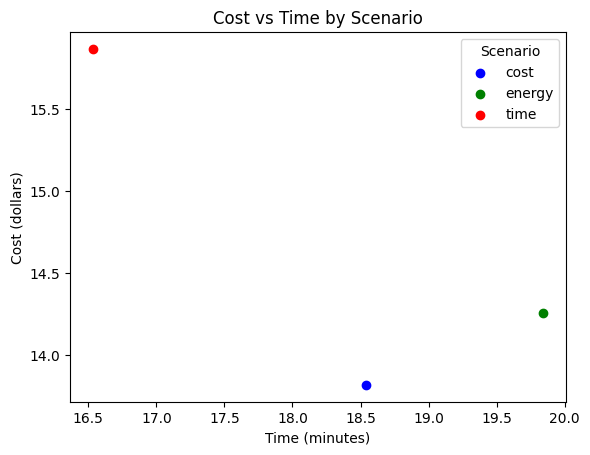

In [18]:
fig, ax = plt.subplots()
colors = {'time':'red', 'cost':'blue', 'energy':'green'}

for scenario, group in df.groupby('scenario'):
    ax.scatter(group['time_minutes'], group['cost_dollars'], color=colors[scenario], label=scenario)

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Cost (dollars)')
ax.legend(title='Scenario')
plt.title('Cost vs Time by Scenario')

For this route, the least time rotuee is two minutes faster than the least cost route and four minutes faster than the least energy route but it does increase the overall cost by 1-2 dollars based on the cost assumptions provided with the query.

Next, let's look at the time versus energy tradeoff

Text(0.5, 1.0, 'Cost vs Energy by Scenario')

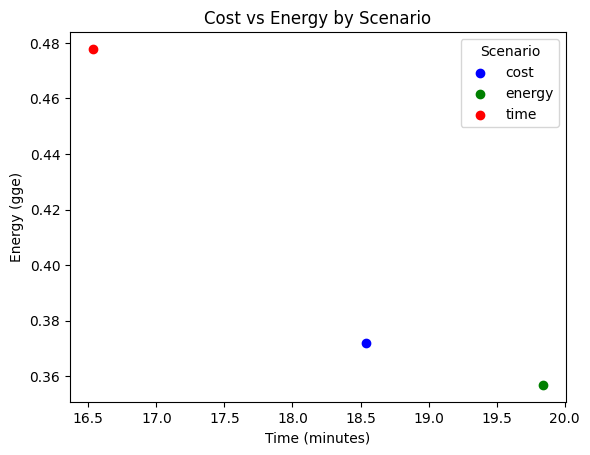

In [34]:
fig, ax = plt.subplots()
colors = {'time':'red', 'cost':'blue', 'energy':'green'}

for scenario, group in df.groupby('scenario'):
    ax.scatter(group['time_minutes'], group['energy_gge'], color=colors[scenario], label=scenario)

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Energy (gge)')
ax.legend(title='Scenario')
plt.title('Cost vs Energy by Scenario')

Here we see the formation of a pareto-like front where the least time and least energy routes provide extreme tradeoffs between energy and time whereas the least cost route fall in between them.